In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
from pathlib import Path
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
from mtrain.label_studio.extract_frags import extract_from_single_result, run_kmeans, ImageSaver

In [20]:
def extract_and_show(content):
    crops = []
    for _, sample in enumerate(content):
        crops.extend(extract_from_single_result(sample))
    _, ax = plt.subplots(1, 4)
    for (c, a) in zip(crops[:4], ax):
        a.imshow(c)
    plt.tight_layout()
    plt.show()
    return crops

In [22]:
saver = ImageSaver(Path("../../datasets/crops/v3"))

In [5]:
with open("/Users/hariomnarang/Downloads/project-6-at-2026-01-20-08-41-6fcf9bb6.json") as f:
    content = json.load(f)

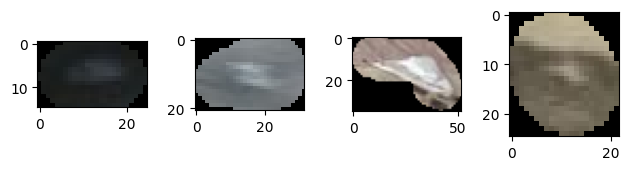

In [6]:
crops = extract_and_show(content)

In [13]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_show_kmeans(labels, ax):
    unique_labels = np.unique(labels)
    
    if ax is None:
        ax = plt.gca()  # use current axes if not provided

    # Discrete colormap for labels
    cmap = ListedColormap(plt.get_cmap('tab10').colors[:len(unique_labels)])
    norm = BoundaryNorm(np.arange(len(unique_labels)+1)-0.5, len(unique_labels))
    
    # Show image
    im = ax.imshow(labels, cmap=cmap, norm=norm, interpolation='nearest')
    
    # Colorbar (attached to the figure containing the axes)
    cbar = ax.figure.colorbar(im, ax=ax, ticks=range(len(unique_labels)))
    cbar.ax.set_yticklabels(unique_labels)
    
    ax.set_xticks([])
    ax.set_yticks([])

    return ax, im, cbar


def get_image_of_kmeans_class(img, lbls, clazz):
    res = np.zeros(img.shape, dtype=np.uint8)
    mask = lbls == clazz
    res[mask] = img[mask]
    return res

In [ ]:
index = 0

In [132]:
index += 1

In [133]:
lbls = run_kmeans(crops[index], 3)
f, ax = plt.subplots(1, 2)
ax[0].imshow(crops[index])
plot_show_kmeans(lbls, ax[1])
plt.show()

IndexError: list index out of range

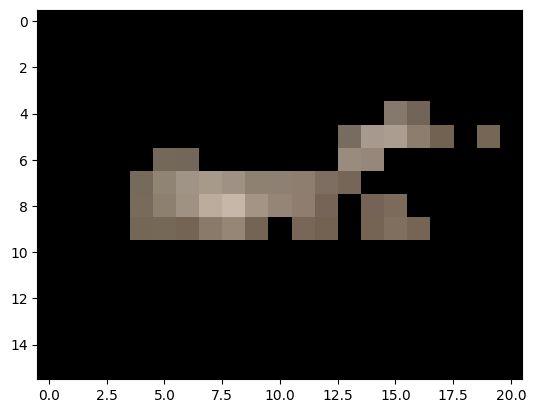

In [130]:
lbl_cls = 1
res = get_image_of_kmeans_class(crops[index], lbls, lbl_cls)
plt.imshow(res)
plt.show()

In [131]:
saver.save(res, index)

PosixPath('../../datasets/crops/v3/10.png')

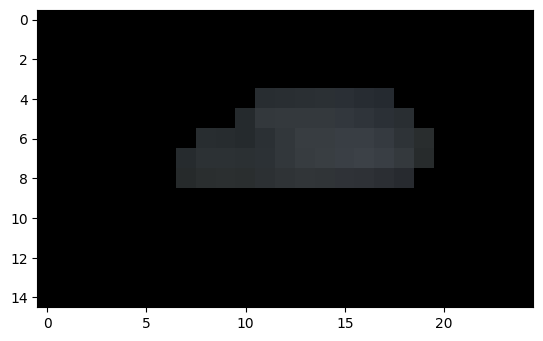

In [4]:
# =========================
# Standard imports
# =========================
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display
import ipywidgets as widgets

from mtrain.label_studio.extract_frags import extract_kmeans_label, run_kmeans, plot_kmeans_labels


# ============================================================
# Assumed existing functions (DEFINED ELSEWHERE IN NOTEBOOK)
# ------------------------------------------------------------
# def run_kmeans(img_bgr, K=3):
#     ...
#
# def plot_kmeans_labels(labels, ax=None, title="labels"):
#     ...
#
# def extract_kmeans_label(orig, lbl, include_cls):
#     ...
# ============================================================


class KMeansExplorer:
    """
    Interactive KMeans exploration + save tool for notebooks.

    Workflow:
    - Slider controls K
    - Image is reclustered on change
    - Original + label visualization are shown side-by-side
    - User selects label class(es) to extract
    - Save button extracts and writes masked crop to disk
    """

    def __init__(self, img_path, out_dir):
        self.img_path = Path(img_path)
        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(parents=True, exist_ok=True)

        # Load image
        self.img_bgr = cv2.imread(str(self.img_path))
        if self.img_bgr is None:
            raise ValueError(f"Could not load image: {img_path}")

        # Internal state
        self.labels = None
        self.current_K = None

        # Build UI
        self._build_widgets()

    # --------------------------------------------------------
    # Widget construction
    # --------------------------------------------------------
    def _build_widgets(self):
        self.k_slider = widgets.IntSlider(
            value=3,
            min=2,
            max=15,
            step=1,
            description="K",
            continuous_update=False
        )

        self.class_input = widgets.Text(
            value="0",
            description="Label(s)",
            placeholder="e.g. 0 or 1,2"
        )

        self.save_button = widgets.Button(
            description="Save",
            button_style="success"
        )

        self.out = widgets.Output()

        # Wire callbacks
        self.k_slider.observe(self._on_k_change, names="value")
        self.save_button.on_click(self._on_save)

    # --------------------------------------------------------
    # K slider → recompute + redraw
    # --------------------------------------------------------
    def _on_k_change(self, change=None):
        K = self.k_slider.value
        self.save_button.disabled = True

        # Run kmeans
        labels = run_kmeans(self.img_bgr, K=K)

        # Update state
        self.labels = labels
        self.current_K = K

        # Redraw
        with self.out:
            self.out.clear_output(wait=True)
            self._plot_current(labels)

        self.save_button.disabled = False

    # --------------------------------------------------------
    # Plot original + labels
    # --------------------------------------------------------
    def _plot_current(self, labels):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Original image
        axes[0].imshow(cv2.cvtColor(self.img_bgr, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original")
        axes[0].axis("off")

        # KMeans labels
        plot_kmeans_labels(
            labels,
            ax=axes[1],
            title=f"KMeans Labels (K={self.current_K})"
        )

        plt.tight_layout()
        plt.show()

    # --------------------------------------------------------
    # Save button → extract selected class(es)
    # --------------------------------------------------------
    def _on_save(self, button):
        if self.labels is None:
            print("Nothing to save yet.")
            return

        # Parse user input
        try:
            include_cls = [int(x.strip()) for x in self.class_input.value.split(",")]
        except ValueError:
            print("Invalid label input. Use comma-separated integers.")
            return

        crop = extract_kmeans_label(
            self.img_bgr,
            self.labels,
            include_cls
        )

        out_path = self.out_dir / "proc.png"
        cv2.imwrite(str(out_path), crop)

        with self.out:
            print(f"Saved label(s) {include_cls} → {out_path}")

    # --------------------------------------------------------
    # Public entrypoint
    # --------------------------------------------------------
    def display(self):
        ui = widgets.VBox([
            self.k_slider,
            self.class_input,
            self.save_button,
            self.out
        ])

        display(ui)

        # Initial render
        self._on_k_change()

In [2]:
ui = KMeansExplorer("/Users/hariomnarang/Desktop/personal/roads/datasets/crops/raw/10.png", "outputs")
ui.display()

In [5]:
# =========================
# Standard imports
# =========================
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display
import ipywidgets as widgets


# ============================================================
# Assumed existing functions (DEFINED ELSEWHERE IN NOTEBOOK)
# ------------------------------------------------------------
# def run_kmeans(img_bgr, K=3):
#     ...
#
# def plot_kmeans_labels(labels, ax=None, title="labels"):
#     ...
#
# def extract_kmeans_label(orig, lbl, include_cls):
#     ...
# ============================================================


class KMeansDatasetExplorer:
    """
    Interactive KMeans explorer over a dataset of images.

    Features:
    - Navigate through images (Prev / Next / Skip)
    - Adjust K per image
    - Visualize original + labels
    - Extract selected label(s)
    - Save result per image
    """

    def __init__(self, images, out_dir):
        """
        images: list of paths OR directory path
        out_dir: directory to save outputs
        """
        self.images = self._load_images(images)
        if len(self.images) == 0:
            raise ValueError("No images found.")

        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(parents=True, exist_ok=True)

        # Dataset state
        self.idx = 0
        self.img_bgr = None
        self.labels = None
        self.current_K = None

        # UI
        self._build_widgets()
        self._load_current_image()

    # --------------------------------------------------------
    # Image loading
    # --------------------------------------------------------
    def _load_images(self, images):
        if isinstance(images, (str, Path)):
            images = sorted(Path(images).glob("*"))
        return [Path(p) for p in images]

    # --------------------------------------------------------
    # Widget construction
    # --------------------------------------------------------
    def _build_widgets(self):
        self.k_slider = widgets.IntSlider(
            value=3,
            min=2,
            max=15,
            step=1,
            description="K",
            continuous_update=False
        )

        self.class_input = widgets.Text(
            value="0",
            description="Label(s)",
            placeholder="e.g. 0 or 1,2"
        )

        self.prev_button = widgets.Button(description="◀ Prev")
        self.next_button = widgets.Button(description="Next ▶")
        self.skip_button = widgets.Button(description="Skip ⏭")
        self.save_button = widgets.Button(
            description="Save",
            button_style="success"
        )

        self.status = widgets.HTML()
        self.out = widgets.Output()

        # Callbacks
        self.k_slider.observe(self._on_k_change, names="value")
        self.save_button.on_click(self._on_save)
        self.next_button.on_click(lambda b: self._move(+1))
        self.prev_button.on_click(lambda b: self._move(-1))
        self.skip_button.on_click(lambda b: self._move(+1, skipped=True))

    # --------------------------------------------------------
    # Navigation
    # --------------------------------------------------------
    def _move(self, step, skipped=False):
        self.idx = np.clip(self.idx + step, 0, len(self.images) - 1)
        self._load_current_image()

    # --------------------------------------------------------
    # Load current image
    # --------------------------------------------------------
    def _load_current_image(self):
        img_path = self.images[self.idx]
        self.img_bgr = cv2.imread(str(img_path))
        if self.img_bgr is None:
            raise ValueError(f"Could not load image: {img_path}")

        # Reset per-image state
        self.labels = None
        self.current_K = None

        self.status.value = (
            f"<b>Image {self.idx + 1}/{len(self.images)}</b>: "
            f"{img_path.name}"
        )

        # Trigger clustering
        self._on_k_change()

    # --------------------------------------------------------
    # K slider → recompute + redraw
    # --------------------------------------------------------
    def _on_k_change(self, change=None):
        self.save_button.disabled = True

        K = self.k_slider.value
        labels = run_kmeans(self.img_bgr, K=K)

        self.labels = labels
        self.current_K = K

        with self.out:
            self.out.clear_output(wait=True)
            self._plot_current()

        self.save_button.disabled = False

    # --------------------------------------------------------
    # Plot original + labels
    # --------------------------------------------------------
    def _plot_current(self):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Original
        axes[0].imshow(cv2.cvtColor(self.img_bgr, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original")
        axes[0].axis("off")

        # Labels
        plot_kmeans_labels(
            self.labels,
            ax=axes[1],
            title=f"KMeans (K={self.current_K})"
        )

        plt.tight_layout()
        plt.show()

    # --------------------------------------------------------
    # Save current extraction
    # --------------------------------------------------------
    def _on_save(self, button):
        if self.labels is None:
            print("Nothing to save.")
            return

        try:
            include_cls = [int(x.strip()) for x in self.class_input.value.split(",")]
        except ValueError:
            print("Invalid label input.")
            return

        crop = extract_kmeans_label(
            self.img_bgr,
            self.labels,
            include_cls
        )

        img_name = self.images[self.idx].stem
        out_path = self.out_dir / f"{img_name}_K{self.current_K}_cls{include_cls}.png"

        cv2.imwrite(str(out_path), crop)

        with self.out:
            print(f"Saved → {out_path}")

    # --------------------------------------------------------
    # Display UI
    # --------------------------------------------------------
    def display(self):
        nav = widgets.HBox([
            self.prev_button,
            self.next_button,
            self.skip_button
        ])

        ui = widgets.VBox([
            self.status,
            nav,
            self.k_slider,
            self.class_input,
            self.save_button,
            self.out
        ])

        display(ui)

In [6]:
explor = KMeansDatasetExplorer([
    "/Users/hariomnarang/Desktop/personal/roads/datasets/crops/raw/9.png",
    "/Users/hariomnarang/Desktop/personal/roads/datasets/crops/raw/10.png",
    "/Users/hariomnarang/Desktop/personal/roads/datasets/crops/raw/11.png",
], "./output")

In [7]:
explor.display()